In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

# Configure pandas options for better display
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
# Function to load dataset
def load_data(file_path: str) -> pd.DataFrame:
    """
    Load dataset from a given file path.

    Args:
        file_path (str): The path to the CSV file.

    Returns:
        pd.DataFrame: The loaded data as a pandas DataFrame.
    """
    return pd.read_csv(file_path)

In [3]:
# Load dataset
df = load_data('../data/raw/Customer_Data.csv')

# Standardize column names to lowercase
df.columns = map(str.lower, df.columns)

# Drop customer ID as it's not needed for analysis
if 'cust_id' in df.columns:
    df.drop('cust_id', axis=1, inplace=True)

In [4]:
# Display basic information about the dataset
print("Dataframe shape:", df.shape)
print("First 5 rows of the dataset:\n", df.head())
print("Dataset description:\n", df.describe())
print("Number of duplicate rows:", df.duplicated().sum())
print("Random sample of data (transposed):\n", df.sample(5).T)

Dataframe shape: (8950, 17)
First 5 rows of the dataset:
    balance  balance_frequency  purchases  oneoff_purchases  \
0    40.90               0.82      95.40              0.00   
1 3,202.47               0.91       0.00              0.00   
2 2,495.15               1.00     773.17            773.17   
3 1,666.67               0.64   1,499.00          1,499.00   
4   817.71               1.00      16.00             16.00   

   installments_purchases  cash_advance  purchases_frequency  \
0                   95.40          0.00                 0.17   
1                    0.00      6,442.95                 0.00   
2                    0.00          0.00                 1.00   
3                    0.00        205.79                 0.08   
4                    0.00          0.00                 0.08   

   oneoff_purchases_frequency  purchases_installments_frequency  \
0                        0.00                              0.08   
1                        0.00                     

In [5]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values:\n", missing_values[missing_values > 0])

Missing values:
 credit_limit          1
minimum_payments    313
dtype: int64


In [6]:
# Display random samples from key columns with missing data
print("Sample of minimum_payments:\n", df['minimum_payments'].sample(10))
print("Sample of credit_limit:\n", df['credit_limit'].sample(10))

Sample of minimum_payments:
 7709     353.22
7604     138.85
3908   1,592.56
1477     373.68
6525     997.92
3344      74.06
3337     455.41
523      163.16
6336     469.21
5192        NaN
Name: minimum_payments, dtype: float64
Sample of credit_limit:
 1376   2,500.00
1521   3,000.00
1131   5,000.00
1907   9,500.00
6131   6,000.00
5423   6,000.00
5872   1,000.00
1404   2,000.00
4406   6,000.00
6783   4,000.00
Name: credit_limit, dtype: float64


In [7]:
# Impute missing values using the median for columns with missing data
columns_to_impute = ['minimum_payments', 'credit_limit']
imputer = SimpleImputer(strategy='median')
df[columns_to_impute] = imputer.fit_transform(df[columns_to_impute])
print("Missing values after imputation:\n", df[columns_to_impute].isnull().sum())


Missing values after imputation:
 minimum_payments    0
credit_limit        0
dtype: int64


In [8]:
# Function to detect outliers using IQR method
def detect_outliers_iqr(df: pd.DataFrame, sample_limit: int = 3) -> pd.DataFrame:
    """
    Detects outliers in a DataFrame using the Interquartile Range (IQR) method.

    Args:
        df (pd.DataFrame): The input DataFrame.
        sample_limit (int, optional): Maximum number of outliers to sample per column. Defaults to 3.

    Returns:
        pd.DataFrame: Summary DataFrame of detected outliers for each numerical column.
    """
    outliers_summary = []
    for column in df.select_dtypes(include=['float64', 'int64']).columns:
        Q1, Q3 = df[column].quantile(0.25), df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound, upper_bound = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        outlier_count = len(outliers)
        outlier_percentage = (outlier_count / len(df)) * 100
        # Collect statistics
        summary = {
            "Column": column,
            "Total Observations": len(df),
            "Number of Outliers": outlier_count,
            "Outlier Percentage (%)": round(outlier_percentage, 2),
            "Mean": round(df[column].mean(), 2),
            "Median": round(df[column].median(), 2),
            "Standard Deviation": round(df[column].std(), 2),
            "Skewness": round(df[column].skew(), 2),
            "Kurtosis": round(df[column].kurt(), 2),
            "Sample Outliers": outliers.head(sample_limit).to_dict(orient='records') if outlier_count > 0 else "None"
        }
        outliers_summary.append(summary)
    return pd.DataFrame(outliers_summary)

# Detect outliers in the dataset
outliers_summary_df = detect_outliers_iqr(df, sample_limit=3)

# Display outlier summary
print("Outlier Summary:")
print(outliers_summary_df)

Outlier Summary:
                              Column  Total Observations  Number of Outliers  \
0                            balance                8950                 695   
1                  balance_frequency                8950                1493   
2                          purchases                8950                 808   
3                   oneoff_purchases                8950                1013   
4             installments_purchases                8950                 867   
5                       cash_advance                8950                1030   
6                purchases_frequency                8950                   0   
7         oneoff_purchases_frequency                8950                 782   
8   purchases_installments_frequency                8950                   0   
9             cash_advance_frequency                8950                 525   
10                  cash_advance_trx                8950                 804   
11                     

In [9]:
# Function to treat outliers using capping method
def treat_outliers(df: pd.DataFrame, outliers_summary_df: pd.DataFrame, method: str = 'cap') -> pd.DataFrame:
    """
    Treat outliers by capping or removing them.

    Args:
        df (pd.DataFrame): The input DataFrame.
        outliers_summary_df (pd.DataFrame): Outlier summary DataFrame.
        method (str, optional): Method to treat outliers ('cap' or 'remove'). Defaults to 'cap'.

    Returns:
        pd.DataFrame: DataFrame with treated outliers.
    """
    df_cleaned = df.copy()
    for index, row in outliers_summary_df.iterrows():
        column = row['Column']
        Q1, Q3 = df[column].quantile(0.25), df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound, upper_bound = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
        if method == 'cap':
            # Cap outliers
            df_cleaned[column] = df_cleaned[column].clip(lower_bound, upper_bound)
        elif method == 'remove':
            # Remove rows with outliers
            outliers = df_cleaned[(df_cleaned[column] < lower_bound) | (df_cleaned[column] > upper_bound)]
            df_cleaned.drop(outliers.index, inplace=True)
    return df_cleaned

# Treat outliers using the capping method
df_cleaned = treat_outliers(df, outliers_summary_df, method='cap')

# Display cleaned data
print("Cleaned Data (First 5 rows):\n", df_cleaned.head())

Cleaned Data (First 5 rows):
    balance  balance_frequency  purchases  oneoff_purchases  \
0    40.90               0.82      95.40              0.00   
1 3,202.47               0.91       0.00              0.00   
2 2,495.15               1.00     773.17            773.17   
3 1,666.67               0.72   1,499.00          1,443.51   
4   817.71               1.00      16.00             16.00   

   installments_purchases  cash_advance  purchases_frequency  \
0                   95.40          0.00                 0.17   
1                    0.00      2,784.55                 0.00   
2                    0.00          0.00                 1.00   
3                    0.00        205.79                 0.08   
4                    0.00          0.00                 0.08   

   oneoff_purchases_frequency  purchases_installments_frequency  \
0                        0.00                              0.08   
1                        0.00                              0.00   
2          

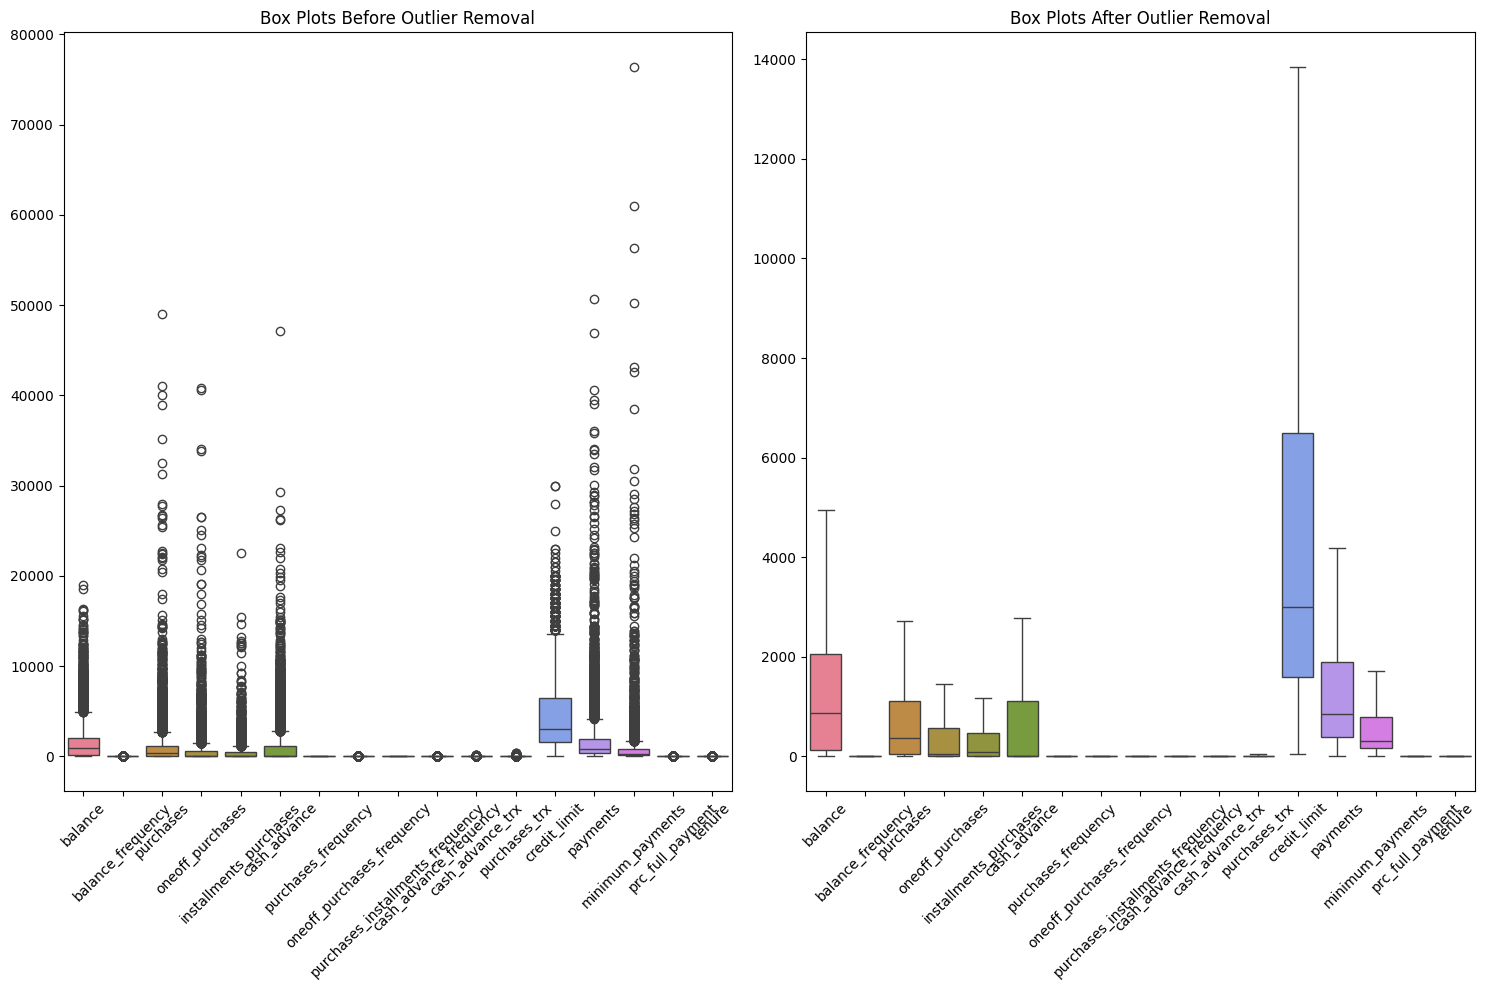

In [10]:
# Function to plot box plots before and after outlier treatment
def plot_boxplots_before_after(original_data: pd.DataFrame, cleaned_data: pd.DataFrame):
    """
    Plot box plots to compare original and cleaned datasets before and after outlier removal.
    
    Args:
        original_data (pd.DataFrame): The original DataFrame.
        cleaned_data (pd.DataFrame): The cleaned DataFrame after outlier removal.
    """
    # Get all numerical columns
    numerical_columns = original_data.select_dtypes(include=['float64', 'int64']).columns.tolist()
    
    plt.figure(figsize=(15, 10))

    # Original data box plots
    plt.subplot(1, 2, 1)
    sns.boxplot(data=original_data[numerical_columns])
    plt.title('Box Plots Before Outlier Removal')
    plt.xticks(rotation=45)

    # Cleaned data box plots
    plt.subplot(1, 2, 2)
    sns.boxplot(data=cleaned_data[numerical_columns])
    plt.title('Box Plots After Outlier Removal')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

# Plot box plots for all features
plot_boxplots_before_after(df, df_cleaned)

In [11]:
# Function to detect skewness and kurtosis
def detect_skewness_kurtosis(df: pd.DataFrame) -> pd.DataFrame:
    """
    Detect skewness and kurtosis for numerical columns in a DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        pd.DataFrame: A DataFrame summarizing skewness and kurtosis for each numerical column.
    """
    summary = []
    for column in df.select_dtypes(include=['float64', 'int64']).columns:
        summary.append({
            "Column": column,
            "Skewness": round(df[column].skew(), 2),
            "Kurtosis": round(df[column].kurt(), 2),
            "Mean": round(df[column].mean(), 2),
            "Median": round(df[column].median(), 2),
            "Standard Deviation": round(df[column].std(), 2)
        })
    return pd.DataFrame(summary)

# Detect skewness and kurtosis
skewness_kurtosis_summary_df = detect_skewness_kurtosis(df_cleaned)

# Display skewness and kurtosis summary
print("\nSkewness and Kurtosis Summary:")
print(skewness_kurtosis_summary_df)


Skewness and Kurtosis Summary:
                              Column  Skewness  Kurtosis     Mean   Median  \
0                            balance      1.17      0.20 1,390.51   873.39   
1                  balance_frequency     -1.17     -0.43     0.93     1.00   
2                          purchases      1.21      0.15   737.15   361.28   
3                   oneoff_purchases      1.24     -0.03   354.36    38.00   
4             installments_purchases      1.22      0.09   295.55    89.00   
5                       cash_advance      1.24     -0.04   672.47     0.00   
6                purchases_frequency      0.06     -1.64     0.49     0.50   
7         oneoff_purchases_frequency      1.25      0.12     0.18     0.08   
8   purchases_installments_frequency      0.51     -1.40     0.36     0.17   
9             cash_advance_frequency      1.27      0.42     0.13     0.00   
10                  cash_advance_trx      1.28      0.19     2.38     0.00   
11                     purchases

In [12]:
# Function to fix skewness and kurtosis
def fix_skewness_kurtosis(df: pd.DataFrame, summary_df: pd.DataFrame, skew_threshold: float = 0.5, kurt_threshold: float = 3) -> pd.DataFrame:
    """
    Fix skewness and kurtosis in the dataset using transformations.

    Args:
        df (pd.DataFrame): The input DataFrame.
        summary_df (pd.DataFrame): Summary DataFrame with skewness and kurtosis info.
        skew_threshold (float, optional): Threshold to decide skewness. Defaults to 0.5.
        kurt_threshold (float, optional): Threshold to decide kurtosis. Defaults to 3.

    Returns:
        pd.DataFrame: Transformed DataFrame with fixed skewness and kurtosis.
    """
    df_transformed = df.copy()
    for _, row in summary_df.iterrows():
        column = row['Column']
        skewness, kurtosis = row['Skewness'], row['Kurtosis']
        if skewness > skew_threshold:
            # Apply log transformation for positive skewness
            df_transformed[column] = np.log1p(df_transformed[column].clip(lower=0))
        elif skewness < -skew_threshold:
            # Apply square root transformation for negative skewness
            df_transformed[column] = np.sqrt(df_transformed[column].clip(lower=0))
        # Optionally handle kurtosis if needed (skipped here)
    return df_transformed


In [13]:
# Fix skewness in the dataset
df_fixed_skewness = fix_skewness_kurtosis(df_cleaned, skewness_kurtosis_summary_df)

# Display transformed data
print("\nTransformed Data (First 5 rows):\n", df_fixed_skewness.head())


Transformed Data (First 5 rows):
    balance  balance_frequency  purchases  oneoff_purchases  \
0     3.74               0.90       4.57              0.00   
1     8.07               0.95       0.00              0.00   
2     7.82               1.00       6.65              6.65   
3     7.42               0.85       7.31              7.28   
4     6.71               1.00       2.83              2.83   

   installments_purchases  cash_advance  purchases_frequency  \
0                    4.57          0.00                 0.17   
1                    0.00          7.93                 0.00   
2                    0.00          0.00                 1.00   
3                    0.00          5.33                 0.08   
4                    0.00          0.00                 0.08   

   oneoff_purchases_frequency  purchases_installments_frequency  \
0                        0.00                              0.08   
1                        0.00                              0.00   
2     

In [14]:
# Plot skewness before and after fixing
def plot_skewness_comparison(original_summary: pd.DataFrame, fixed_summary: pd.DataFrame):
    """
    Plot comparison of skewness before and after fixing.

    Args:
        original_summary (pd.DataFrame): Summary before fixing.
        fixed_summary (pd.DataFrame): Summary after fixing.
    """
    plt.figure(figsize=(12, 6))
    bar_width = 0.35
    index = np.arange(len(original_summary))  # Get the range of indices for x-axis

    # Plot the skewness before fixing
    plt.bar(index, original_summary['skewness'], bar_width, label='Before Fixing', alpha=0.7)

    # Plot the skewness after fixing
    plt.bar(index + bar_width, fixed_summary['skewness'], bar_width, label='After Fixing', alpha=0.7)

    # Labels and title
    plt.xlabel('Features', fontsize=12)
    plt.ylabel('Skewness', fontsize=12)
    plt.title('Comparison of Skewness Before and After Fixing', fontsize=15)
    plt.xticks(index + bar_width / 2, original_summary.index, rotation=90)  # Feature names on x-axis
    plt.legend()

    # Display the plot
    plt.tight_layout()
    plt.show()

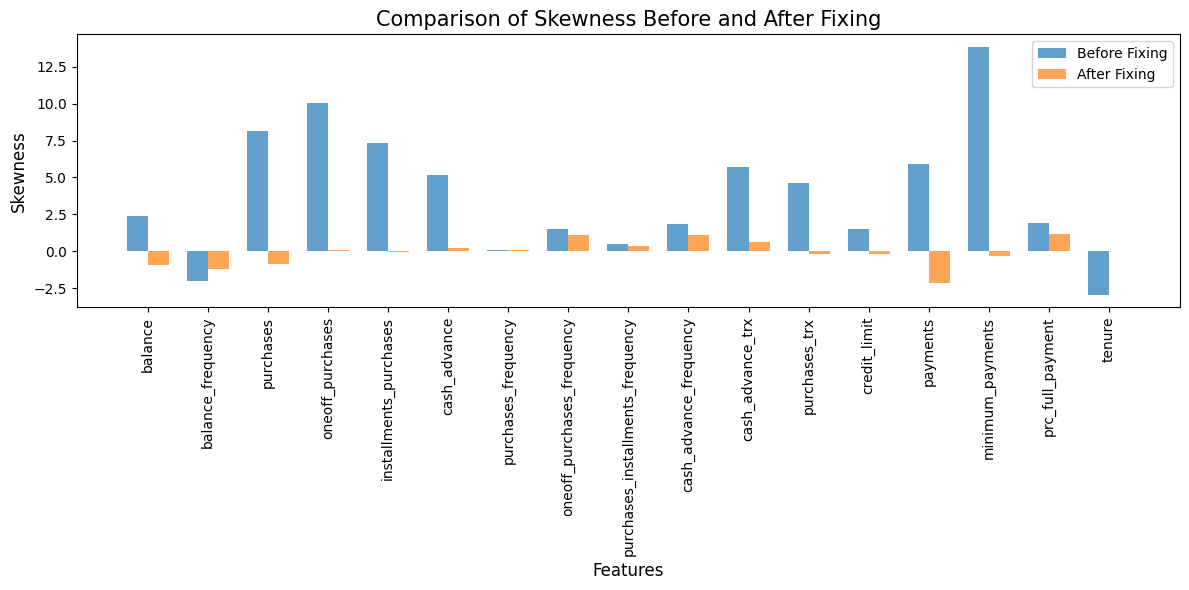

In [15]:
#  before and after summary
original_summary = df.describe().T[['mean', 'std', 'min', '25%', '50%', '75%', 'max']]
fixed_summary = df_fixed_skewness.describe().T[['mean', 'std', 'min', '25%', '50%', '75%', 'max']]

# Adding skewness to summaries
original_summary['skewness'] = df.skew()
fixed_summary['skewness'] = df_fixed_skewness.skew()

# Plot the comparison
plot_skewness_comparison(original_summary, fixed_summary)

In [16]:
import os

# Optional: Save the cleaned and transformed dataset to a new CSV file
def save_cleaned_data(df: pd.DataFrame, file_path: str):
    """
    Save the cleaned and transformed dataset to a CSV file.

    Args:
        df (pd.DataFrame): The input DataFrame.
        file_path (str): The path where the CSV will be saved.
    """
    # Ensure that the directory exists
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    # Save the DataFrame to CSV
    df.to_csv(file_path, index=False)
    print(f"Cleaned data saved to {file_path}")

# Save the final cleaned dataset
save_cleaned_data(df_fixed_skewness, '../data/processed/Cleaned_Customer_Data.csv')



Cleaned data saved to ../data/processed/Cleaned_Customer_Data.csv


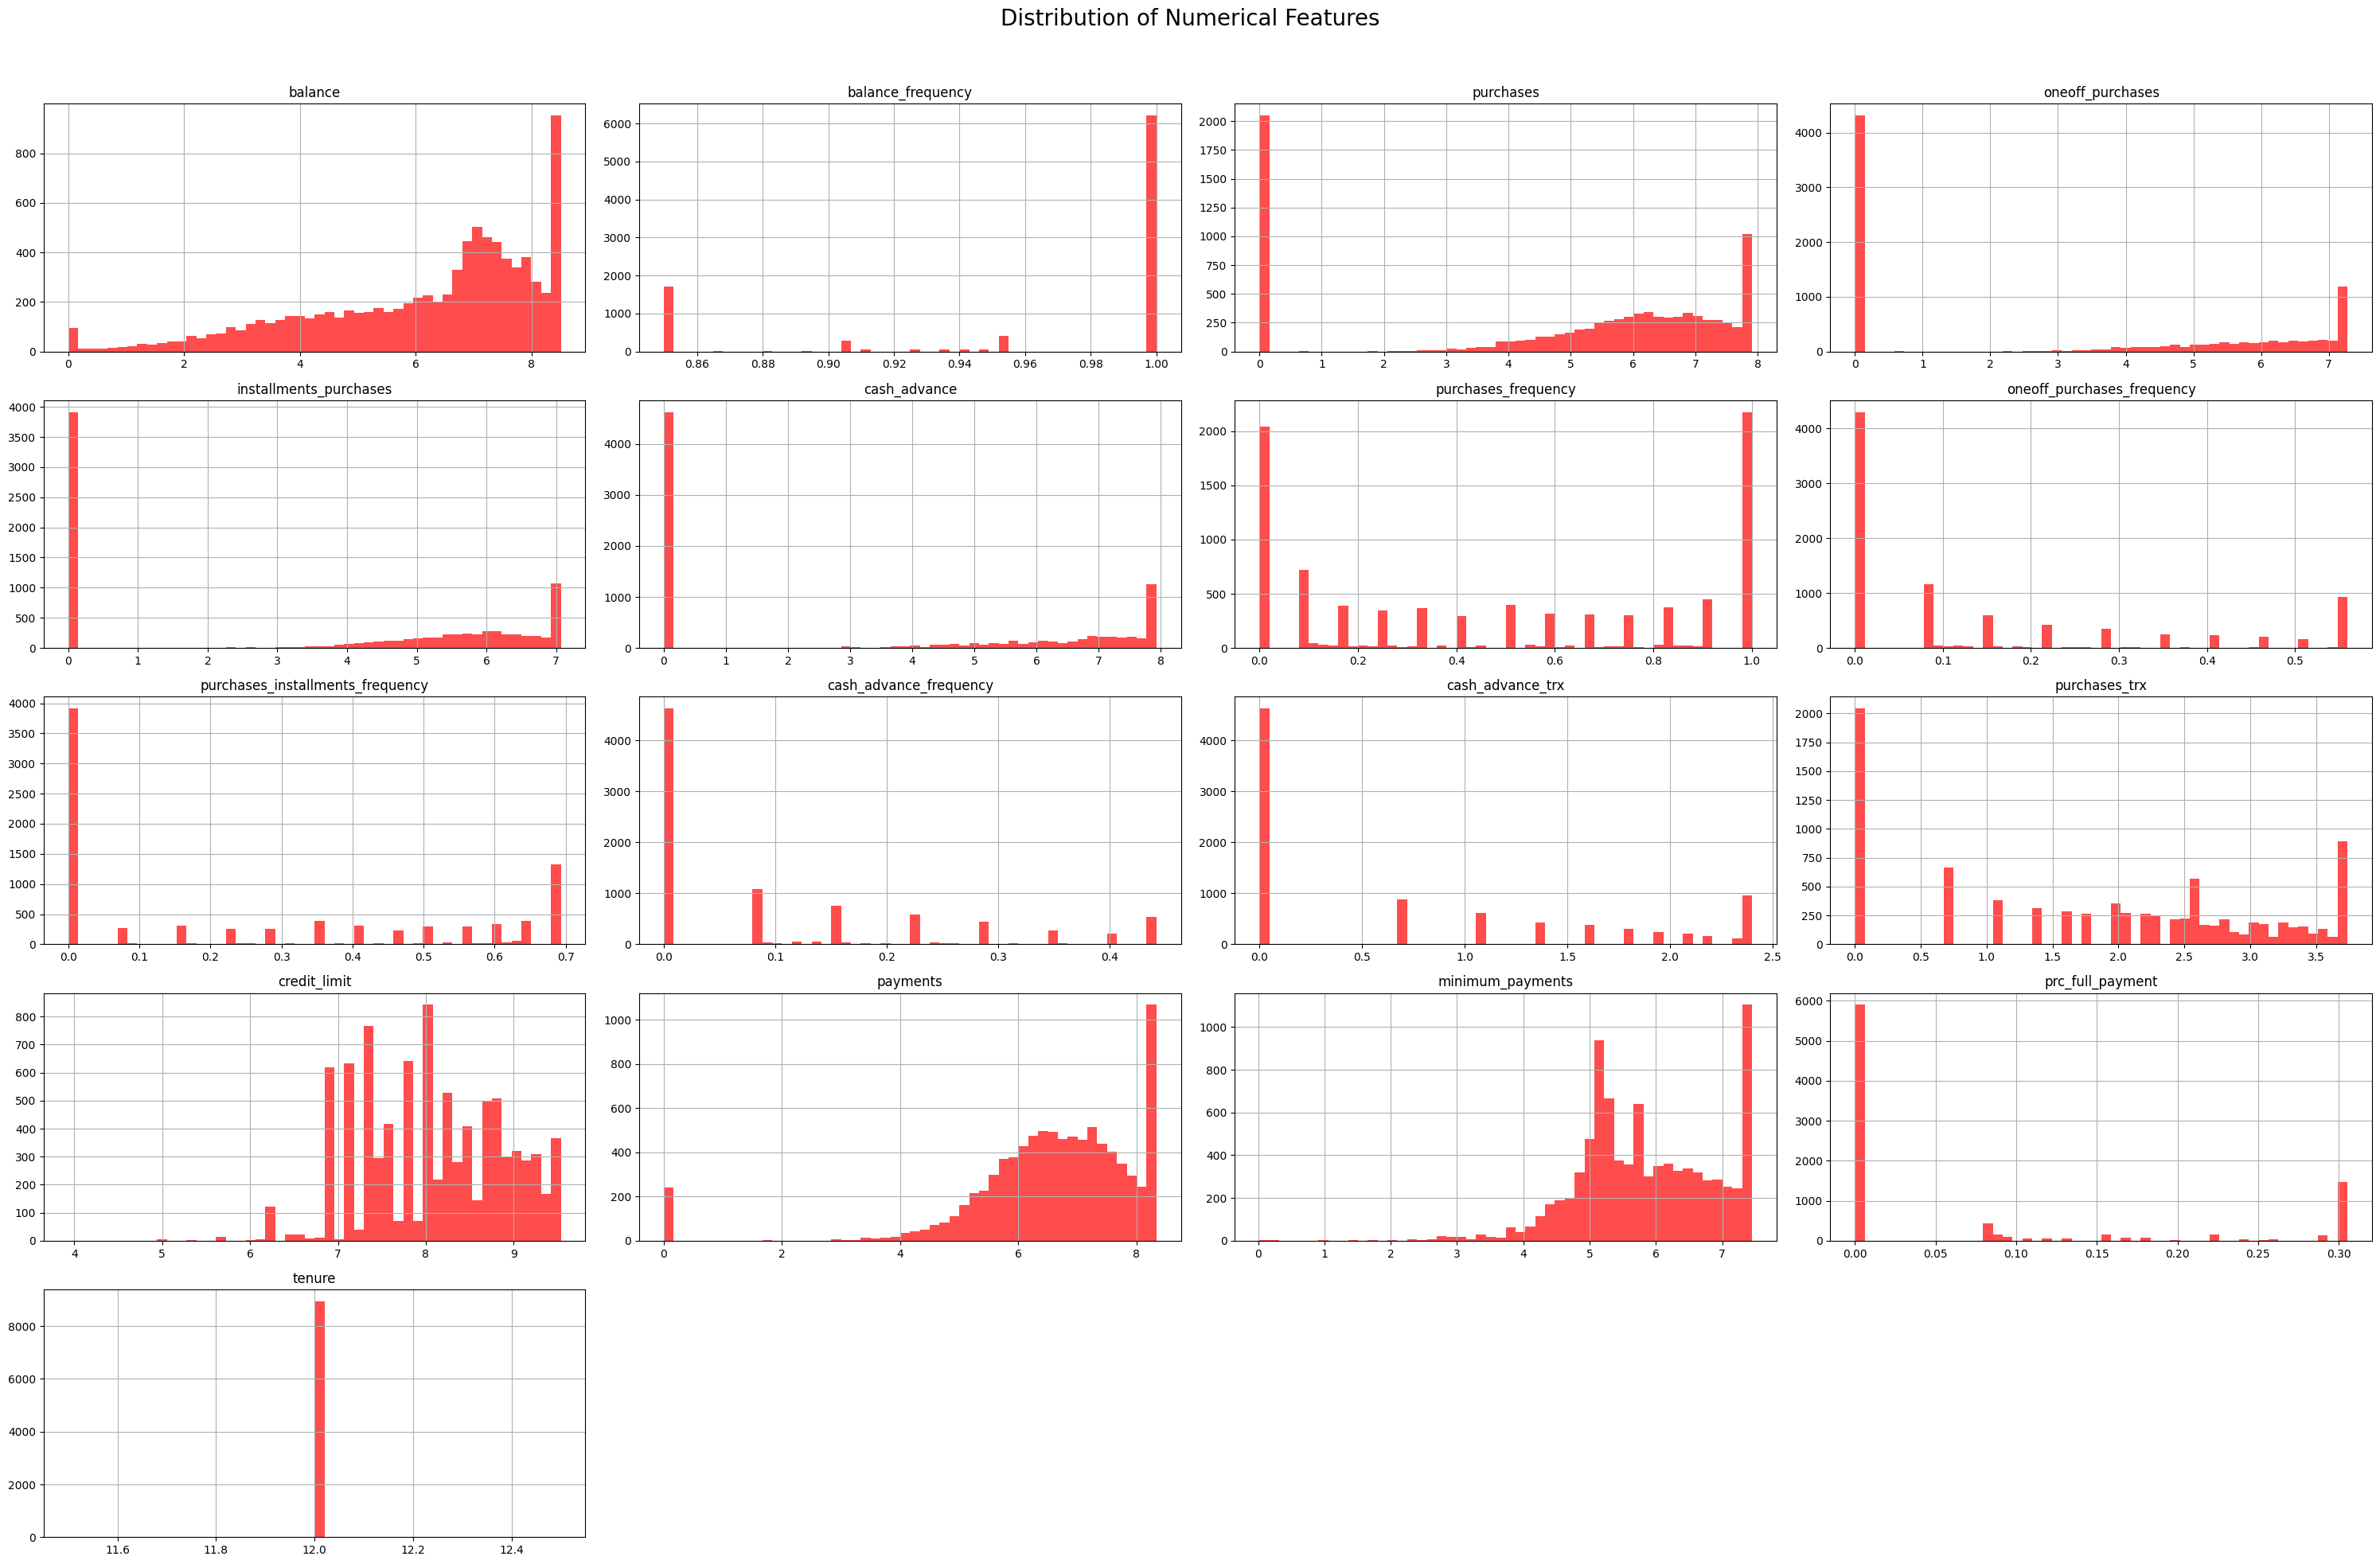

In [17]:
import matplotlib.pyplot as plt

# Distribution plot to visualize data distribution
def plot_all_feature_distributions(df: pd.DataFrame):
    """
    Plot histograms for the distributions of each numerical feature in the DataFrame.
    
    Args:
        df (pd.DataFrame): The input DataFrame with cleaned data.
    """
    # Plot histograms for all numerical columns in the DataFrame
    hist_plot = df.hist(bins=50, figsize=(30, 20), grid=True, color='red', alpha=0.7)

    # Set title for the overall plot
    plt.suptitle('Distribution of Numerical Features', fontsize=20)
    plt.xlabel('Value', fontsize=15)
    plt.ylabel('Frequency', fontsize=15)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to prevent overlap with suptitle
    plt.show()

# Call the function to plot distributions for cleaned data
plot_all_feature_distributions(df_fixed_skewness)


In [18]:
df_fixed_skewness.head()

,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure
0,3.74,0.90,4.57,0.00,4.57,0.00,0.17,0.00,0.08,0.00,0.00,1.10,6.91,5.31,4.95,0.00,12
1,8.07,0.95,0.00,0.00,0.00,7.93,0.00,0.00,0.00,0.22,1.61,0.00,8.85,8.32,6.98,0.20,12
2,7.82,1.00,6.65,6.65,0.00,0.00,1.00,0.56,0.00,0.00,0.00,2.56,8.92,6.43,6.44,0.00,12
3,7.42,0.85,7.31,7.28,0.00,5.33,0.08,0.08,0.00,0.08,0.69,0.69,8.92,0.00,5.75,0.00,12
4,6.71,1.00,2.83,2.83,0.00,0.00,0.08,0.08,0.00,0.00,0.00,0.69,7.09,6.52,5.50,0.00,12


MODELING

In [20]:
# creating new variable for modeling
df_model = df_fixed_skewness.copy()

In [21]:
import pandas as pd
import numpy as np

def summary_stats(df_model, n=4):
    """
    Generate detailed descriptive statistics for the given DataFrame.

    Parameters:
    df_model (pd.DataFrame): The DataFrame for which to calculate statistics.
    n (int): Number of decimal places to round to.

    Returns:
    pd.DataFrame: A DataFrame containing descriptive statistics for each attribute.
    """
    
    # Calculate central tendency
    mean = pd.DataFrame(df_model.apply(np.mean)).T
    median = pd.DataFrame(df_model.apply(np.median)).T
    
    # Calculate distribution statistics
    std = pd.DataFrame(df_model.apply(np.std)).T
    min_value = pd.DataFrame(df_model.apply(np.min)).T
    max_value = pd.DataFrame(df_model.apply(np.max)).T
    range_value = pd.DataFrame(df_model.apply(lambda x: x.max() - x.min())).T
    skewness = pd.DataFrame(df_model.apply(lambda x: x.skew())).T
    kurtosis = pd.DataFrame(df_model.apply(lambda x: x.kurtosis())).T
    count = pd.DataFrame(df_model.count()).T  # Count of non-null values
    
    # Concatenate all statistics into a single DataFrame
    summary_stats = pd.concat([count, min_value, max_value, range_value, mean, median, std, skewness, kurtosis]).T.reset_index()
    summary_stats.columns = ['Attributes', 'Count', 'Min', 'Max', 'Range', 'Mean', 'Median', 'Std Dev', 'Skewness', 'Kurtosis']
    
    # Format the DataFrame for better readability
    summary_stats['Min'] = summary_stats['Min'].round(n)
    summary_stats['Max'] = summary_stats['Max'].round(n)
    summary_stats['Range'] = summary_stats['Range'].round(n)
    summary_stats['Mean'] = summary_stats['Mean'].round(n)
    summary_stats['Median'] = summary_stats['Median'].round(n)
    summary_stats['Std Dev'] = summary_stats['Std Dev'].round(n)
    summary_stats['Skewness'] = summary_stats['Skewness'].round(n)
    summary_stats['Kurtosis'] = summary_stats['Kurtosis'].round(n)

    # Add a summary section title
    print("Summary Statistics:")
    
    return summary_stats

# descriptive analytic for modeling feature
summary_stats(df_model)


Summary Statistics:


,Attributes,Count,Min,Max,Range,Mean,Median,Std Dev,Skewness,Kurtosis
0,balance,"8,950.00",0.00,8.51,8.51,6.14,6.77,1.98,-0.94,0.22
1,balance_frequency,"8,950.00",0.85,1.00,0.15,0.96,1.00,0.06,-1.19,-0.39
2,purchases,"8,950.00",0.00,7.91,7.91,4.85,5.89,2.85,-0.85,-0.82
3,oneoff_purchases,"8,950.00",0.00,7.28,7.28,3.13,3.66,3.13,0.12,-1.81
4,installments_purchases,"8,950.00",0.00,7.07,7.07,3.30,4.50,3.01,-0.08,-1.82
5,cash_advance,"8,950.00",0.00,7.93,7.93,3.26,0.00,3.47,0.22,-1.81
6,purchases_frequency,"8,950.00",0.00,1.00,1.00,0.49,0.50,0.40,0.06,-1.64
7,oneoff_purchases_frequency,"8,950.00",0.00,0.56,0.56,0.15,0.08,0.20,1.09,-0.27
8,purchases_installments_frequency,"8,950.00",0.00,0.69,0.69,0.27,0.15,0.28,0.37,-1.55
9,cash_advance_frequency,"8,950.00",0.00,0.44,0.44,0.11,0.00,0.14,1.11,-0.04


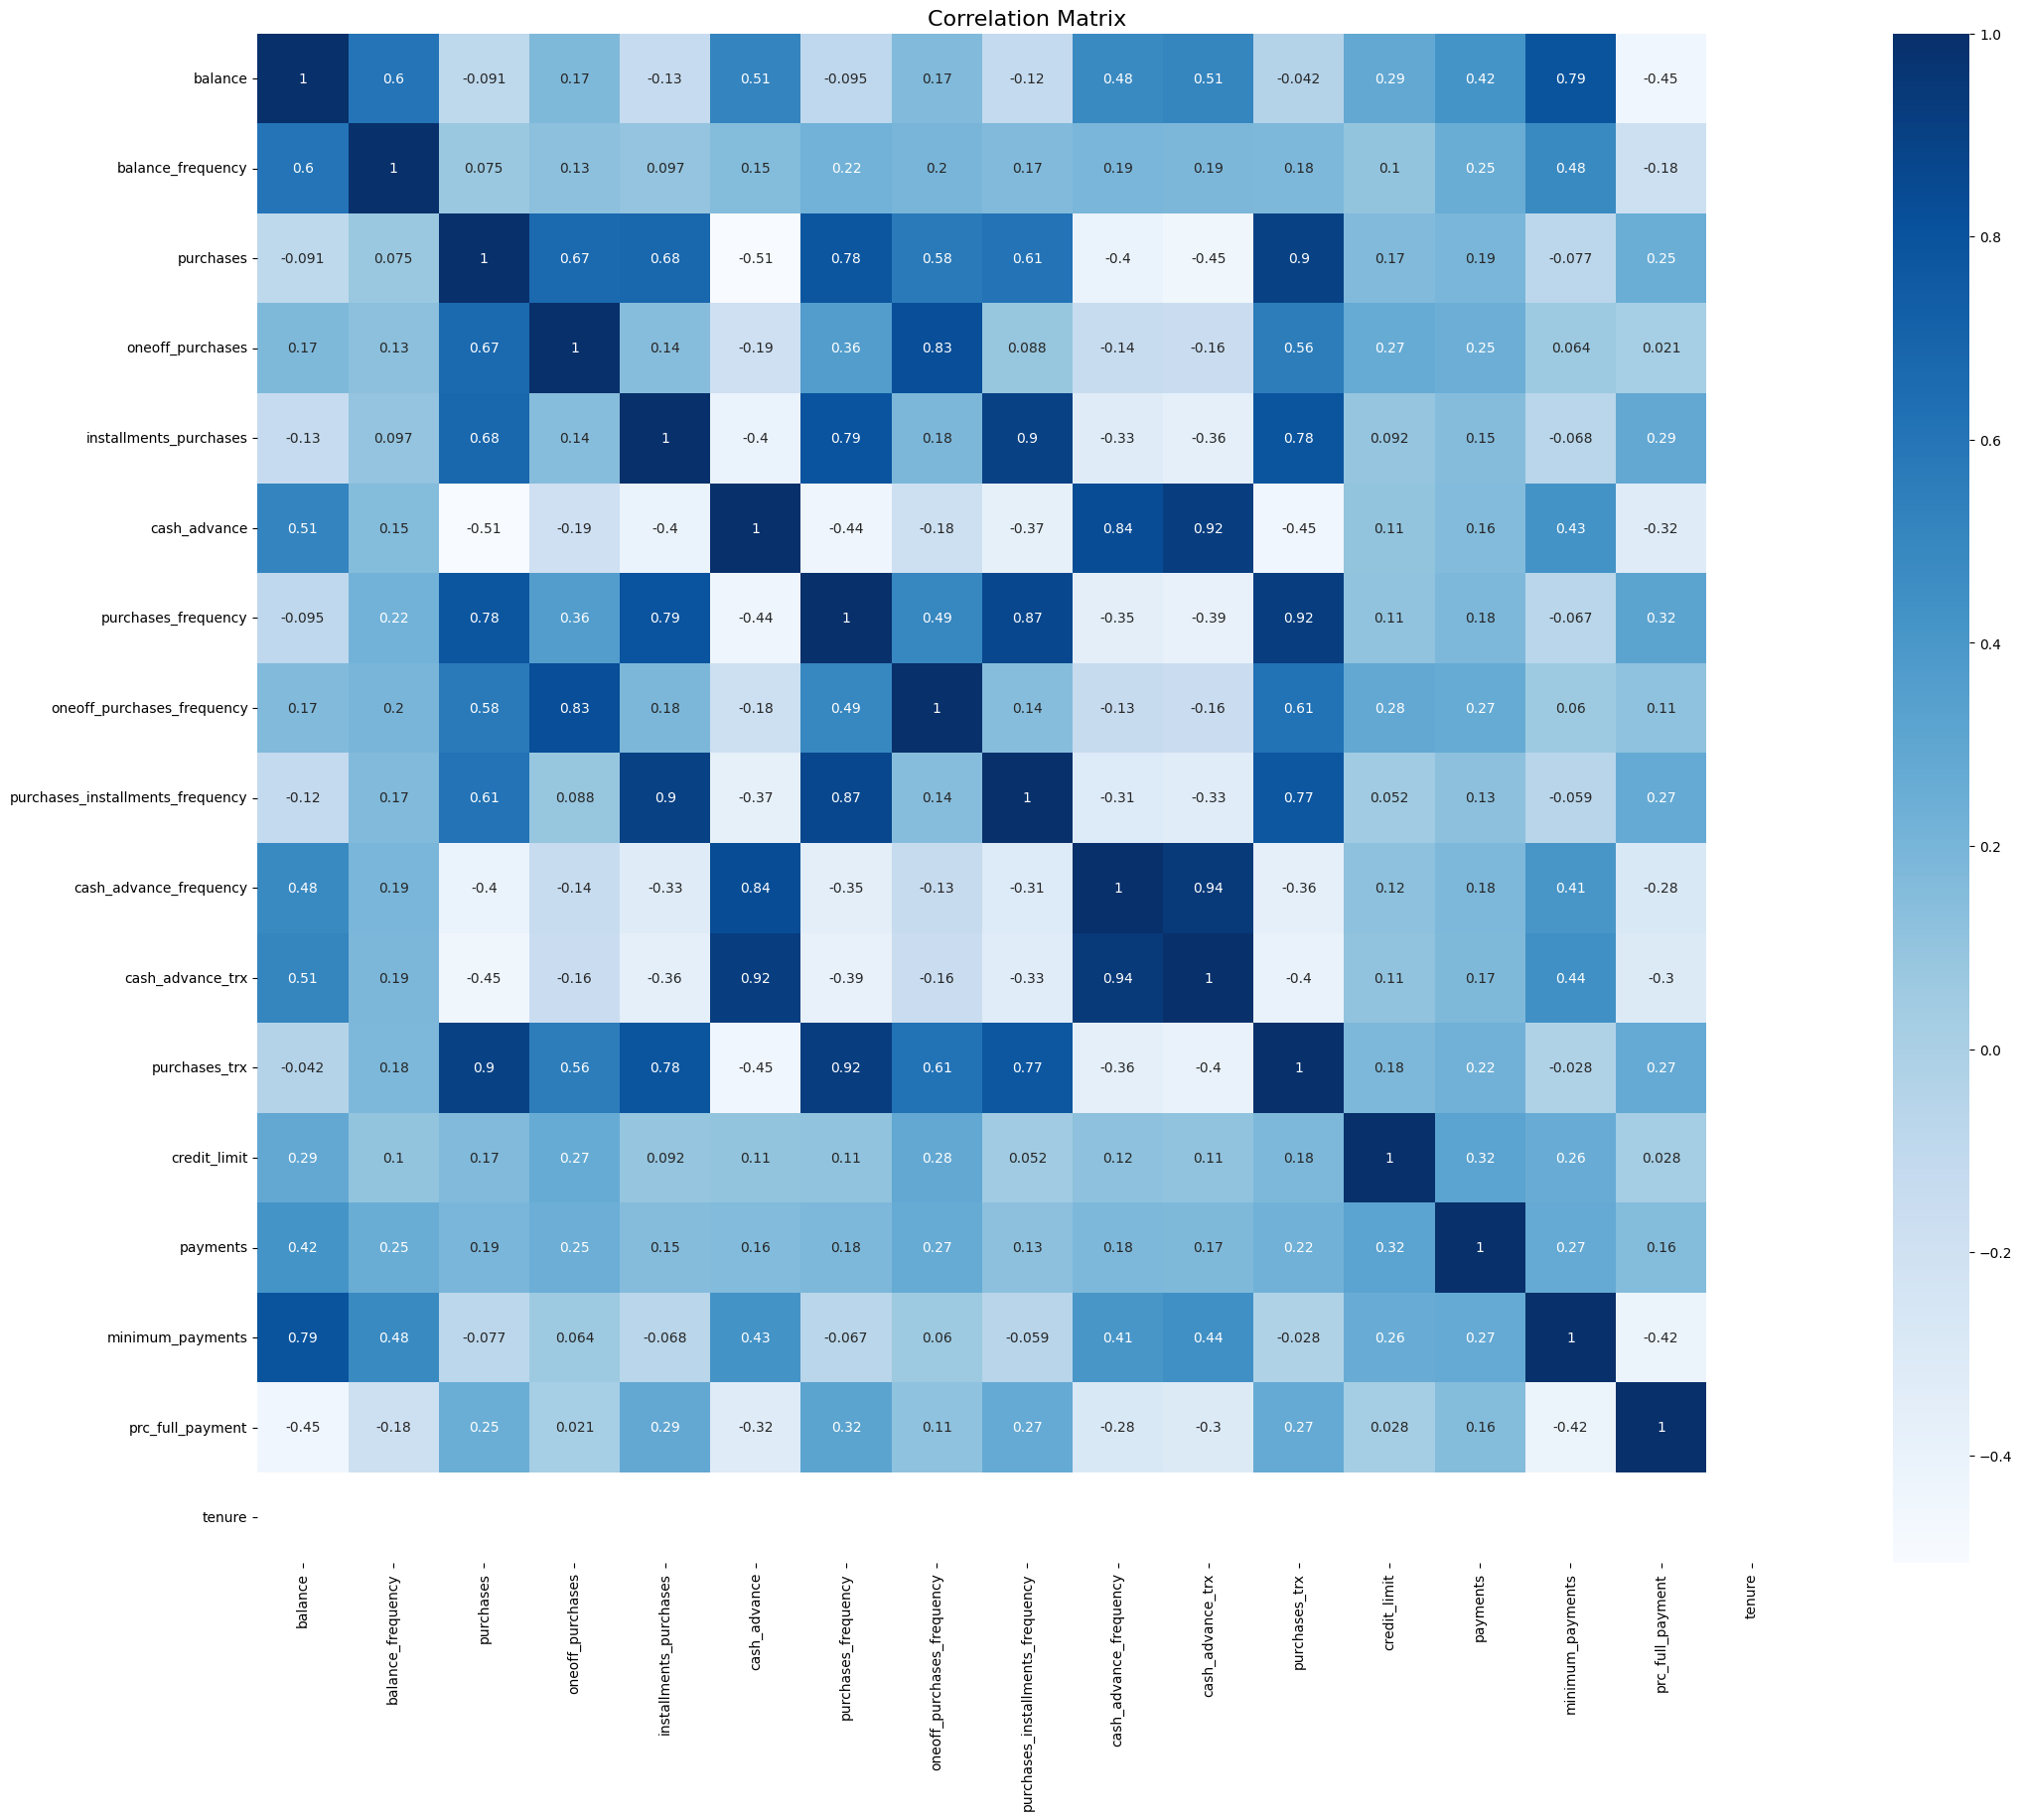

In [22]:
# Step 6: Correlation Matrix and Visualization
correlations = df_model.corr()
plt.figure(figsize=(25, 20))
sns.heatmap(correlations, annot=True, cmap="Blues")
plt.title('Correlation Matrix', fontsize=16)
plt.show()

In [23]:
import pandas as pd

# Assuming df is your DataFrame containing the relevant features
correlations = df_model.corr()

# 1. Set the diagonal to NaN to avoid considering self-correlation
correlation_matrix_no_diag = correlations.where(~np.eye(correlations.shape[0], dtype=bool))

# 2. Find the maximum correlation value and its corresponding feature pair
max_corr_value = correlation_matrix_no_diag.max().max()  # Find the maximum correlation value
max_corr_indices = correlation_matrix_no_diag.stack().idxmax()  # Find the corresponding feature pair

# 3. Find the minimum correlation value and its corresponding feature pair
min_corr_value = correlation_matrix_no_diag.min().min()  # Find the minimum correlation value
min_corr_indices = correlation_matrix_no_diag.stack().idxmin()  # Find the corresponding feature pair

# 4. Display the results
print(f"Maximum correlation value: {max_corr_value} between features: {max_corr_indices}")
print(f"Minimum correlation value: {min_corr_value} between features: {min_corr_indices}")


Maximum correlation value: 0.9420336366437173 between features: ('cash_advance_frequency', 'cash_advance_trx')
Minimum correlation value: -0.50530236287857 between features: ('purchases', 'cash_advance')


In [25]:
import pandas as pd
import numpy as np

# Assuming df is your DataFrame containing the relevant features
correlations = df_model.corr()

# 1. Set the diagonal to NaN to avoid considering self-correlation
correlation_matrix_no_diag = correlations.where(~np.eye(correlations.shape[0], dtype=bool))

# Define correlation thresholds
positive_threshold = 0.7  # Adjust this based on your needs
negative_threshold = 0.5  # Adjust this based on your needs

# 2. Find positive correlations exceeding the threshold
positive_corr_pairs = correlation_matrix_no_diag.stack()[
    correlation_matrix_no_diag.stack() > positive_threshold
].reset_index()

positive_corr_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']
print("Positive correlation pairs (correlation > 0.5):")
print(positive_corr_pairs)

# 3. Find negative correlations below the threshold
negative_corr_pairs = correlation_matrix_no_diag.stack()[
    correlation_matrix_no_diag.stack() < negative_threshold
].reset_index()

negative_corr_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']
print("\nNegative correlation pairs (correlation < -0.5):")
print(negative_corr_pairs)

# 4. Display the maximum and minimum correlation values and their corresponding feature pairs again for context
max_corr_value = correlation_matrix_no_diag.max().max()
max_corr_indices = correlation_matrix_no_diag.stack().idxmax()

min_corr_value = correlation_matrix_no_diag.min().min()
min_corr_indices = correlation_matrix_no_diag.stack().idxmin()

print(f"\nMaximum correlation value: {max_corr_value} between features: {max_corr_indices}")
print(f"Minimum correlation value: {min_corr_value} between features: {min_corr_indices}")


Positive correlation pairs (correlation > 0.5):
                           Feature 1                         Feature 2  \
0                            balance                  minimum_payments   
1                          purchases               purchases_frequency   
2                          purchases                     purchases_trx   
3                   oneoff_purchases        oneoff_purchases_frequency   
4             installments_purchases               purchases_frequency   
5             installments_purchases  purchases_installments_frequency   
6             installments_purchases                     purchases_trx   
7                       cash_advance            cash_advance_frequency   
8                       cash_advance                  cash_advance_trx   
9                purchases_frequency                         purchases   
10               purchases_frequency            installments_purchases   
11               purchases_frequency  purchases_installments_fre

In [27]:
features_to_drop = [
    'purchases_frequency',
    'oneoff_purchases_frequency',
    'purchases_trx',
    'cash_advance_trx',
    'purchases_installments_frequency'
]

# Dropping features from df_model_features
df_model_features = df_model.drop(columns=features_to_drop)

df_model_features.head()

,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,cash_advance_frequency,credit_limit,payments,minimum_payments,prc_full_payment,tenure
0,3.74,0.90,4.57,0.00,4.57,0.00,0.00,6.91,5.31,4.95,0.00,12
1,8.07,0.95,0.00,0.00,0.00,7.93,0.22,8.85,8.32,6.98,0.20,12
2,7.82,1.00,6.65,6.65,0.00,0.00,0.00,8.92,6.43,6.44,0.00,12
3,7.42,0.85,7.31,7.28,0.00,5.33,0.08,8.92,0.00,5.75,0.00,12
4,6.71,1.00,2.83,2.83,0.00,0.00,0.00,7.09,6.52,5.50,0.00,12


In [28]:
df_model_features.dtypes, df_model_features.shape

(balance                   float64
 balance_frequency         float64
 purchases                 float64
 oneoff_purchases          float64
 installments_purchases    float64
 cash_advance              float64
 cash_advance_frequency    float64
 credit_limit              float64
 payments                  float64
 minimum_payments          float64
 prc_full_payment          float64
 tenure                      int64
 dtype: object,
 (8950, 12))

In [29]:
df_model_features.head()

,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,cash_advance_frequency,credit_limit,payments,minimum_payments,prc_full_payment,tenure
0,3.74,0.90,4.57,0.00,4.57,0.00,0.00,6.91,5.31,4.95,0.00,12
1,8.07,0.95,0.00,0.00,0.00,7.93,0.22,8.85,8.32,6.98,0.20,12
2,7.82,1.00,6.65,6.65,0.00,0.00,0.00,8.92,6.43,6.44,0.00,12
3,7.42,0.85,7.31,7.28,0.00,5.33,0.08,8.92,0.00,5.75,0.00,12
4,6.71,1.00,2.83,2.83,0.00,0.00,0.00,7.09,6.52,5.50,0.00,12


In [30]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy import stats

In [29]:
# Feature Engineering

# Create New Features
# df_model_features['purchase_to_payment_ratio'] = df_model_features['purchases'] / (df_model_features['payments'] + 1e-5)
# df_model_features['credit_utilization'] = df_model_features['balance'] / (df_model_features['credit_limit'] + 1e-5)
# df_model_features['avg_purchases_per_month'] = df_model_features['purchases'] / df_model_features['tenure']
# df_model_features['avg_payments_per_month'] = df_model_features['payments'] / df_model_features['tenure']
# df_model_features['purchase_payment_interaction'] = df_model_features['purchases'] * df_model_features['payments']


In [30]:
df_model_features.head()

,balance,balance_frequency,purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure
0,3.74,0.90,4.57,4.57,0.00,0.17,0.00,0.00,1.10,6.91,5.31,4.95,0.00,12
1,8.07,0.95,0.00,0.00,7.93,0.00,0.00,1.61,0.00,8.85,8.32,6.98,0.20,12
2,7.82,1.00,6.65,0.00,0.00,1.00,0.56,0.00,2.56,8.92,6.43,6.44,0.00,12
3,7.42,0.85,7.31,0.00,5.33,0.08,0.08,0.69,0.69,8.92,0.00,5.75,0.00,12
4,6.71,1.00,2.83,0.00,0.00,0.08,0.08,0.00,0.69,7.09,6.52,5.50,0.00,12


In [31]:
df_model_features.shape

(8950, 12)

In [32]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Assuming df_model_features is your DataFrame
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_model_features)

# Create a DataFrame from the scaled features
scaled_df = pd.DataFrame(scaled_features, columns=df_model_features.columns)

# Display the first few rows of the scaled DataFrame
scaled_df.head()


,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,cash_advance_frequency,credit_limit,payments,minimum_payments,prc_full_payment,tenure
0,-1.21,-0.98,-0.10,-1.00,0.42,-0.94,-0.76,-1.46,-0.83,-0.87,-0.64,0.00
1,0.98,-0.17,-1.70,-1.00,-1.10,1.35,0.81,0.94,1.15,1.09,1.04,0.00
2,0.85,0.61,0.63,1.12,-1.10,-0.94,-0.76,1.03,-0.09,0.57,-0.64,0.00
3,0.65,-1.90,0.86,1.32,-1.10,0.60,-0.20,1.03,-4.33,-0.10,-0.64,0.00
4,0.29,0.61,-0.71,-0.09,-1.10,-0.94,-0.76,-1.23,-0.03,-0.33,-0.64,0.00


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming df_model_features is your original DataFrame
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_model_features)

# Convert the scaled features back to a DataFrame
scaled_df = pd.DataFrame(scaled_features, columns=df_model_features.columns)




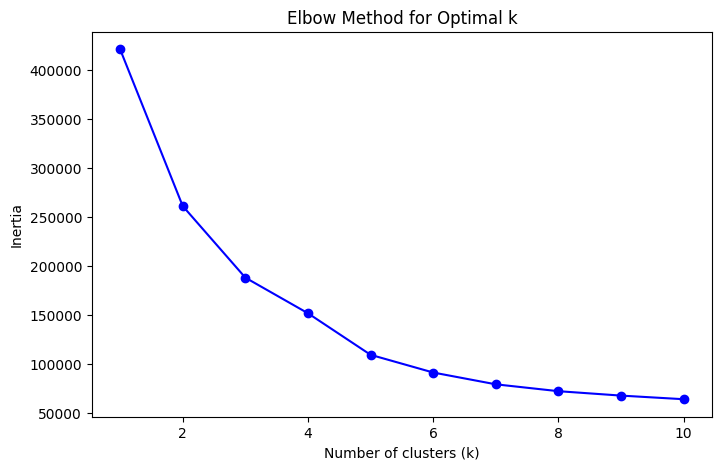

Silhouette Score for KMeans: 0.413


In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Assuming df_model_features is your scaled DataFrame
X = df_model_features

# Elbow Method to find the optimal number of clusters
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

# Choose k based on the elbow and fit KMeans
k_optimal = 4  # replace with your chosen k
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
clusters = kmeans.fit_predict(X)

# Assign cluster labels to the DataFrame
df_model_features['Cluster'] = clusters

# Evaluate with Silhouette Score
silhouette_avg = silhouette_score(X, clusters)
print(f'Silhouette Score for KMeans: {silhouette_avg:.3f}')


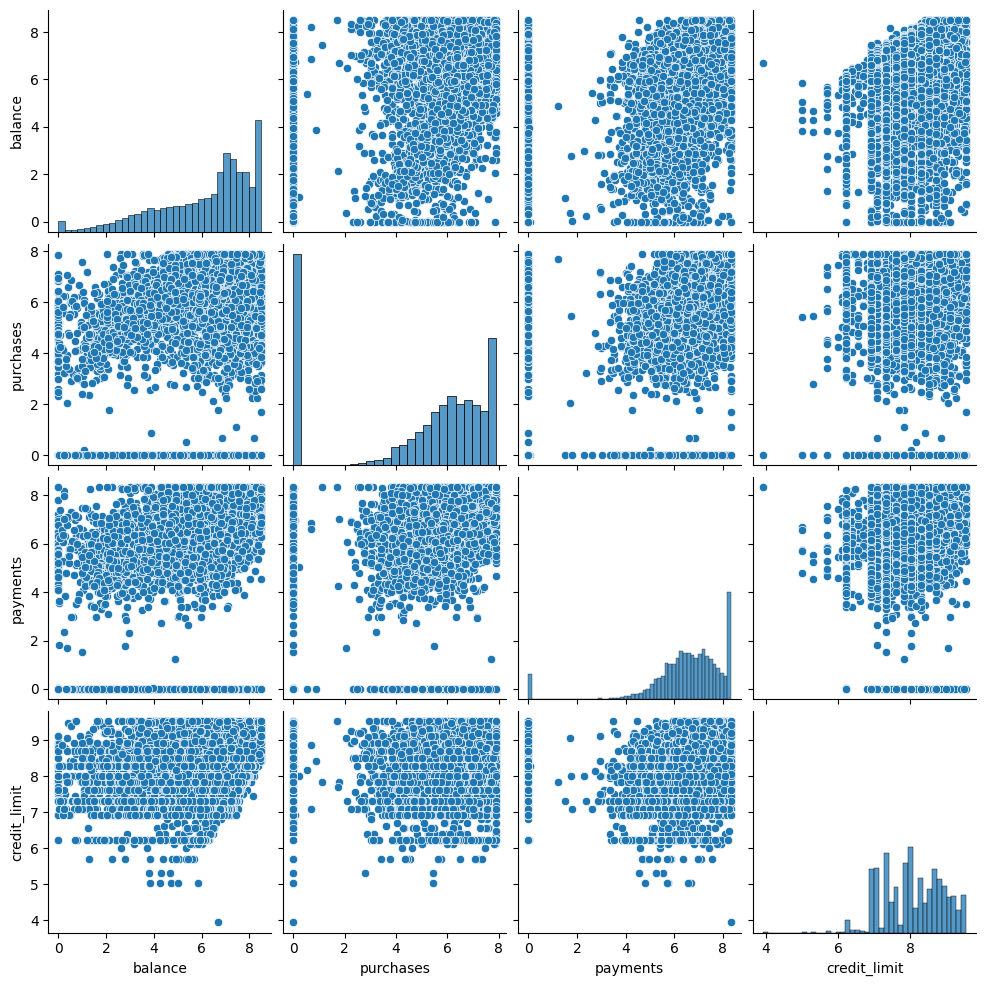

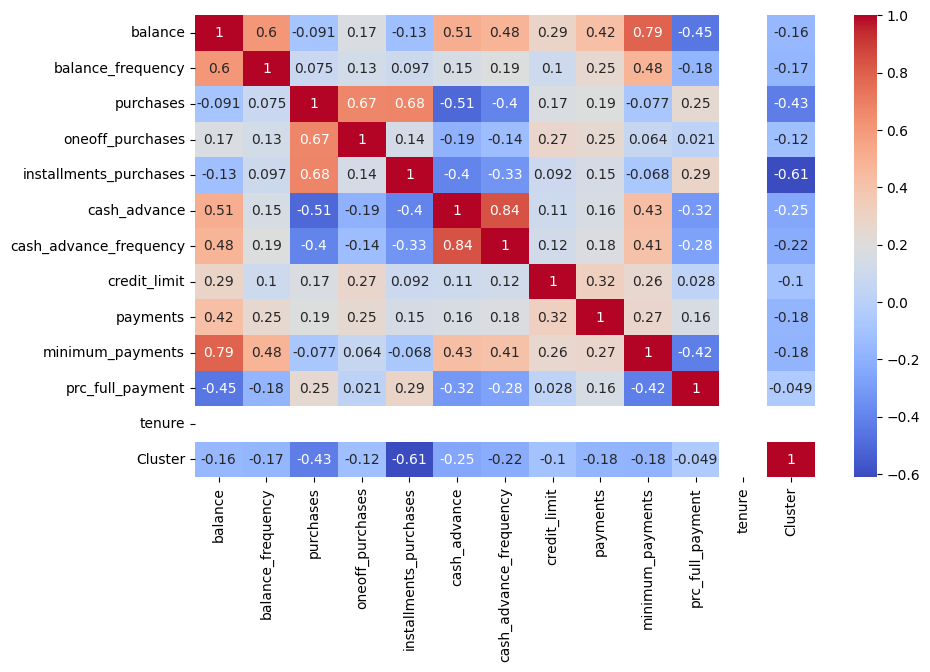

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pairplot for continuous variables
sns.pairplot(df_model_features[['balance', 'purchases', 'payments', 'credit_limit']])
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_model_features.corr(), annot=True, cmap='coolwarm')
plt.show()


In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

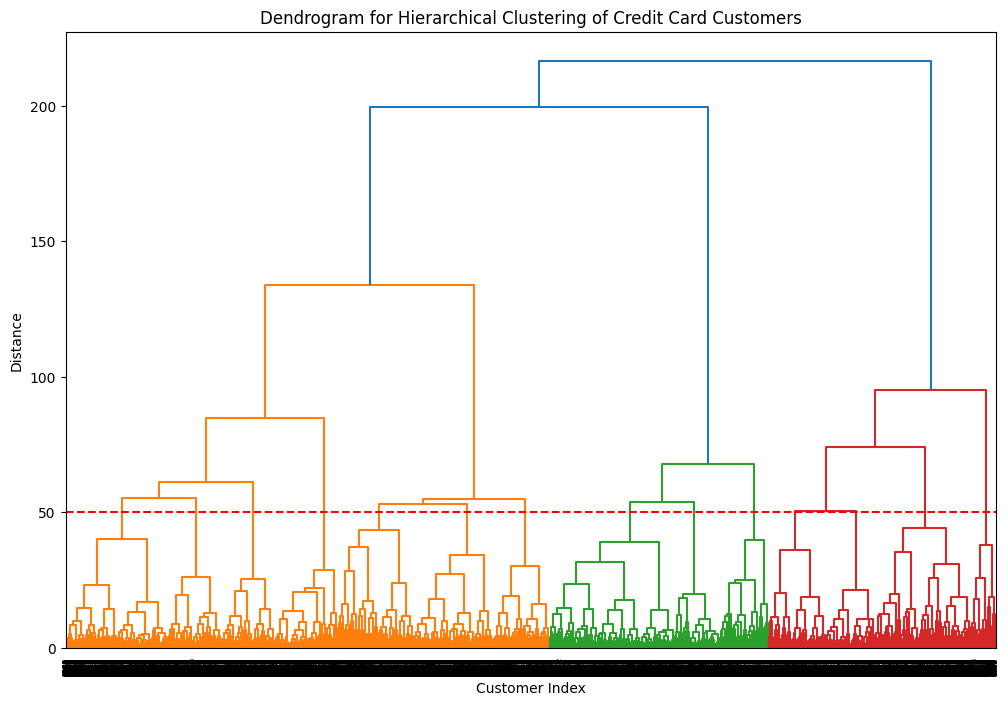

In [52]:
X = np.array(scaled_df)
# Perform hierarchical clustering using Ward's method
linked = linkage(X, method='ward')  # You can try 'single', 'complete', or 'average' as well

# Create a figure for the dendrogram
plt.figure(figsize=(12, 8))

# Create the dendrogram
dendrogram(linked,
           orientation='top',  # Orientation can be 'top', 'left', 'right', or 'bottom'
           labels=np.arange(1, X.shape[0]+1),  # Replace with actual labels if available
           distance_sort='descending',
           show_leaf_counts=True)

# Add title and labels
plt.title('Dendrogram for Hierarchical Clustering of Credit Card Customers')
plt.xlabel('Customer Index')
plt.ylabel('Distance')
plt.axhline(y=50, color='r', linestyle='--')  # Adjust based on your data range to indicate a cluster cut

# Show the plot
plt.show()

In [36]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(scaled_df)


In [37]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters_kmeans = kmeans.fit_predict(scaled_df)

# Silhouette Score
silhouette_avg_kmeans = silhouette_score(scaled_df, clusters_kmeans)
print(f'Silhouette Score for KMeans: {silhouette_avg_kmeans:.3f}')


Silhouette Score for KMeans: 0.221


In [38]:
# Add cluster labels to original DataFrame
scaled_df['Cluster'] = clusters_kmeans

# Profile clusters based on feature means
cluster_profile = df_model_features.groupby('Cluster').mean()
print(cluster_profile)


         balance  balance_frequency  purchases  oneoff_purchases  \
Cluster                                                            
0           7.40               0.98       6.39              4.84   
1           5.17               0.96       6.40              3.01   
2           6.94               0.97       0.10              0.06   
3           5.37               0.94       5.96              5.90   

         installments_purchases  cash_advance  cash_advance_frequency  \
Cluster                                                                 
0                          3.99          6.92                    0.24   
1                          5.91          0.05                    0.00   
2                          0.04          6.70                    0.22   
3                          0.17          0.30                    0.01   

         credit_limit  payments  minimum_payments  prc_full_payment  tenure  
Cluster                                                                   

In [39]:
from sklearn.cluster import AgglomerativeClustering
agg_clustering = AgglomerativeClustering(n_clusters=4)
clusters_agg = agg_clustering.fit_predict(scaled_df)

# Silhouette Score for Agglomerative Clustering
silhouette_avg_agg = silhouette_score(scaled_df, clusters_agg)
print(f'Silhouette Score for Agglomerative Clustering: {silhouette_avg_agg:.3f}')


Silhouette Score for Agglomerative Clustering: 0.267


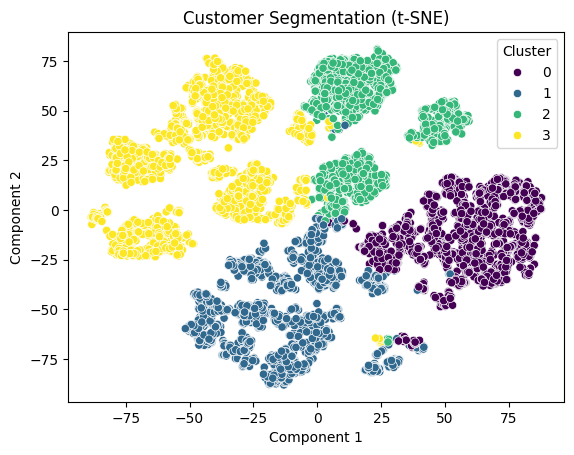

In [40]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(scaled_df)

# Create a DataFrame for visualization
df_tsne = pd.DataFrame(X_tsne, columns=['Component 1', 'Component 2'])
df_tsne['Cluster'] = clusters_kmeans

# Plot
sns.scatterplot(x='Component 1', y='Component 2', hue='Cluster', data=df_tsne, palette='viridis')
plt.title('Customer Segmentation (t-SNE)')
plt.show()


In [41]:
from sklearn.cluster import KMeans

# Assume k_optimal is the chosen number of clusters (you may have determined this using the elbow method)
k_optimal = 4
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
clusters_kmeans = kmeans.fit_predict(scaled_df)

# Add the cluster labels to the DataFrame
scaled_df['Cluster'] = clusters_kmeans

In [42]:
# Profile the clusters based on the mean of each feature
cluster_profile = scaled_df.groupby('Cluster').mean()
print(cluster_profile)

# Optional: View other statistics such as median or count
cluster_profile_median = scaled_df.groupby('Cluster').median()
cluster_profile_count = scaled_df.groupby('Cluster').size()


         balance  balance_frequency  purchases  oneoff_purchases  \
Cluster                                                            
0           0.75               0.41       0.55              0.55   
1           0.20               0.47       0.67              0.61   
2           0.54               0.14      -1.62             -0.95   
3          -1.42              -1.09       0.18             -0.36   

         installments_purchases  cash_advance  cash_advance_frequency  \
Cluster                                                                 
0                          0.23          1.09                    1.00   
1                          0.45         -0.85                   -0.72   
2                         -1.07          1.01                    0.82   
3                          0.23         -0.75                   -0.66   

         credit_limit  payments  minimum_payments  prc_full_payment  tenure  
Cluster                                                                   

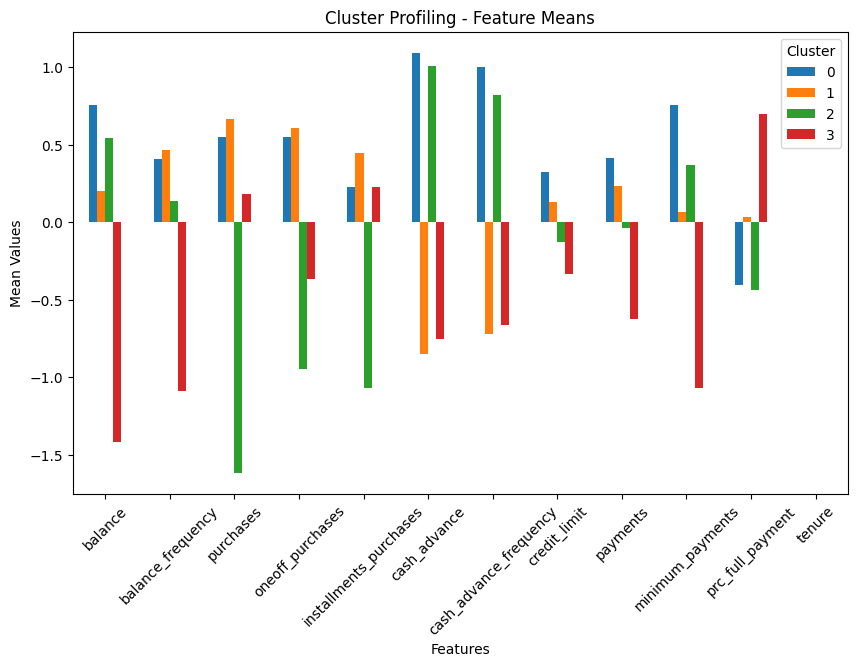

In [43]:
import matplotlib.pyplot as plt

# Transpose the profile data for easier plotting
cluster_profile_T = cluster_profile.T

# Plotting
cluster_profile_T.plot(kind='bar', figsize=(10, 6))
plt.title('Cluster Profiling - Feature Means')
plt.xlabel('Features')
plt.ylabel('Mean Values')
plt.xticks(rotation=45)
plt.legend(title='Cluster')
plt.show()


In [49]:
# Detailed profile with mean, median, min, max for key features
detailed_profile = scaled_df.groupby('Cluster').agg({
    'balance': ['mean', 'median', 'min', 'max'],
    'purchases': ['mean', 'median', 'min', 'max'],
    'payments': ['mean', 'median', 'min', 'max'],
    'credit_limit': ['mean', 'median', 'min', 'max'],
    'oneoff_purchases': ['mean', 'median', 'min', 'max'],  # Added feature
    'installments_purchases': ['mean', 'median', 'min', 'max'],  # Added feature
    'cash_advance': ['mean', 'median', 'min', 'max'],  # Added feature
})

# View the detailed cluster profile
print(detailed_profile)


        balance                   purchases                   payments         \
           mean median   min  max      mean median   min  max     mean median   
Cluster                                                                         
0          0.75   0.81 -0.76 1.20      0.55   0.58 -0.78 1.07     0.41   0.50   
1          0.20   0.28 -1.79 1.20      0.67   0.76 -1.07 1.07     0.23   0.31   
2          0.54   0.59 -1.96 1.20     -1.62  -1.70 -1.70 0.08    -0.04   0.03   
3         -1.42  -1.33 -3.10 0.65      0.18   0.29 -1.70 1.07    -0.62  -0.41   

                   credit_limit                   oneoff_purchases         \
          min  max         mean median   min  max             mean median   
Cluster                                                                     
0       -4.33 1.16         0.33   0.53 -2.94 1.78             0.55   0.84   
1       -4.33 1.16         0.13   0.25 -2.94 1.78             0.61   1.00   
2       -4.33 1.16        -0.12  -0.10 -5.13 1.

# Cluster Profile Summary

## Overall Summary
The clustering analysis has successfully identified **four distinct customer segments** based on credit card usage patterns. These segments exhibit varying levels of **financial stability**, **purchasing behavior**, and **payment reliability**. Understanding these profiles provides valuable insights for tailoring marketing strategies, optimizing customer engagement, and enhancing risk management practices.

---

## Cluster Profiles

### Cluster 0: High Balance and Moderate Purchases
- **Balance**: 
  - High mean (0.75) and median (0.81) values indicate effective account management.
- **Purchases**: 
  - Moderate purchasing activity (mean: 0.55) suggests customers regularly utilize their cards.
- **Payments**: 
  - Positive payment behavior (mean: 0.41) indicates reliability.
- **Credit Limit**: 
  - Effective credit usage reflects financial stability.
- **Cash Advance**: 
  - High mean (1.09) usage suggests some liquidity needs.

**Interpretation**: This cluster represents financially stable customers who actively use their cards for purchases and are generally reliable in payments.

---

### Cluster 1: Moderate Balance with High Purchases
- **Balance**: 
  - Lower balance (mean: 0.20) may indicate less frequent use.
- **Purchases**: 
  - High purchasing activity (mean: 0.67) indicates reliance on credit for spending.
- **Payments**: 
  - Inconsistent payments (mean: 0.23) suggest potential financial stress.
- **Credit Limit**: 
  - Typical range reflects standard credit behavior.
- **Cash Advance**: 
  - Low usage (mean: -0.85) indicates minimal borrowing needs.

**Interpretation**: These customers are active spenders but may face financial challenges, impacting payment reliability.

---

### Cluster 2: Low Purchases with High Cash Advance Usage
- **Balance**: 
  - Moderate balance (mean: 0.54) suggests varied account management.
- **Purchases**: 
  - Negative purchase values (-1.62) indicate low card usage.
- **Payments**: 
  - Variable payments (mean: -0.04) suggest instability.
- **Credit Limit**: 
  - Substantial access to credit.
- **Cash Advance**: 
  - High cash advance usage (mean: 1.01) indicates a dependency on credit.

**Interpretation**: This group may struggle with financial management, relying heavily on cash advances for liquidity.

---

### Cluster 3: Balanced Usage with Inconsistent Payments
- **Balance**: 
  - Negative balance (mean: -1.42) indicates potential overdraft usage.
- **Purchases**: 
  - Moderate spending (mean: 0.18) shows balanced behavior.
- **Payments**: 
  - Inconsistent payments (mean: -0.62) point to possible financial difficulties.
- **Credit Limit**: 
  - Reflects substantial credit access.
- **Cash Advance**: 
  - Moderate usage (mean: 0.23) suggests occasional liquidity needs.

**Interpretation**: These customers display a balanced approach to spending but may experience financial instability affecting payment consistency.

---

## Conclusion
Understanding these profiles allows for **tailored marketing strategies** and improved **risk management**. By leveraging insights into customer behavior, financial products can be personalized, enhancing customer satisfaction and retention.
